<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Copy_of_17_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# For gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_gpj3_fj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_gpj3_fj
  Resolved https://github.com/tensorflow/docs to commit 159143b05575c90bc1217bfa99c76cb5ca27b8d4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=0c0c899cc205f8c24f52037bd6efe2806faaa0cf16af22eb56a840a16e136ea7
  Stored in directory: /tmp/pip-ephem-wheel-cache-f0iwpr6s/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [17]:
# Python ≥3.5 is required
import sys

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import pandas as pd
import os


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Untitled.png

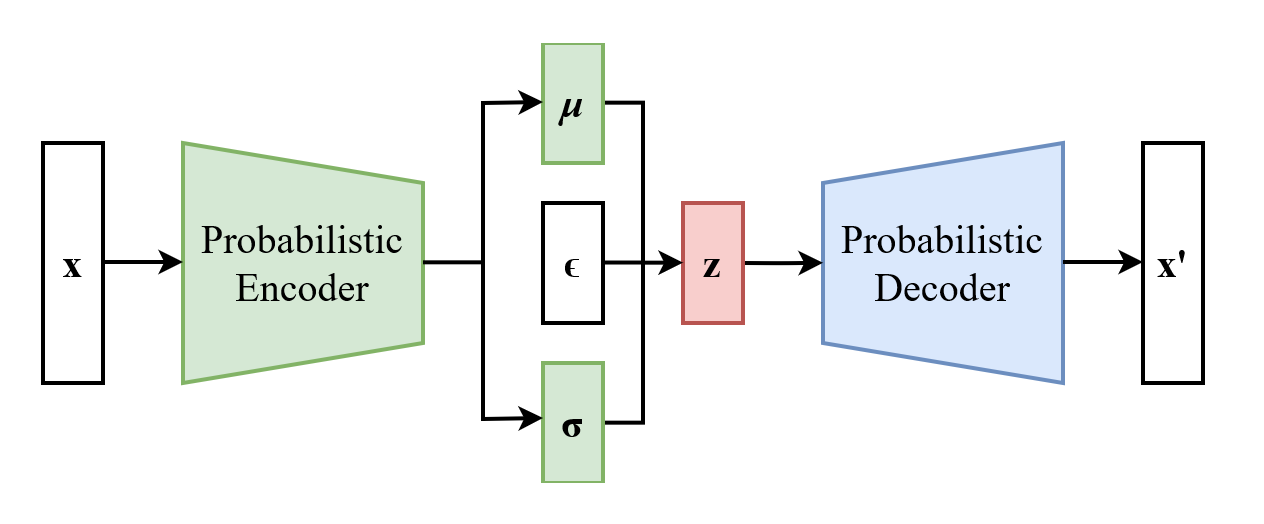

In [9]:
 !pwd

/content


In [10]:
# Where to save the figures:
PROJECT_ROOT_DIR = "."   # /content (default)
CHAPTER_ID = "autoencoders"
# Join path in the order it is written
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Create the folder:
os.makedirs(IMAGES_PATH, exist_ok=True)  # /content/images/autoencoders


In [11]:
# Save figure to folder
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension) # /content/images/autoencoders/xyz.png
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() # automatically adjust so that the subplots fit in figure area.
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale 28x28 image:

In [6]:
# Show an image in grey scale:

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [12]:
np.pi
print("\n=====\n")
3 * np.pi  / 2    # 270 degree or 4.71 radian
print("\n=====\n")
m = 6
np.random.rand(m)  # 0 to 1
print("=====\n")
np.random.rand(m) * 3
print("=====\n")
angles = np.random.rand(m) * 3 * np.pi / 2
angles
print("=====\n")
np.empty((m, 3)) # Array of 6 X 3
print("=====\n")
np.cos(angles)
np.sin(angles)


3.141592653589793


=====



4.71238898038469


=====



array([0.73914782, 0.22053016, 0.10334844, 0.74680064, 0.07028356,
       0.86011901])

=====



array([1.10817627, 1.20400556, 2.96534493, 0.85645466, 0.68160242,
       1.59506034])

=====



array([1.22758822, 1.06419855, 0.1829274 , 3.25771062, 0.7564509 ,
       2.73556764])

=====



array([[4.92528796e-310, 0.00000000e+000, 1.09944918e+155],
       [3.39539598e+044, 2.15037265e-109, 2.30908182e+251],
       [5.98737260e+247, 2.45125193e+198, 1.67494829e+243],
       [6.21813868e+175, 6.01346953e-154, 1.41420116e+195],
       [7.47318933e+252, 1.39622755e+195, 2.21633387e+214],
       [3.03388118e-152, 4.75108964e+233, 1.32654415e-258]])

=====



array([ 0.33650983,  0.48520515,  0.98331539, -0.99326588,  0.72727649,
       -0.91869804])

array([ 0.94167995,  0.87440034,  0.1819089 , -0.11585719,  0.68634459,
        0.39496065])

In [13]:
# Generate some data points:
# m: No of points (1D array):
# w1, w2 etc selected from trial and error

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 #- 0.5
    data = np.empty((m, 3))  # 60 X 3
    # Ist col of data
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    # IInd col of data
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    # IIIrd col of data
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [14]:
X_train = generate_3d_data(60)
X_train = X_train -  X_train.mean(axis=0)   #  X_train.mean(axis=0, keepdims=0)
X_train[:5]

array([[-0.92408171, -0.14719778, -0.06875464],
       [ 0.2520573 ,  0.56147327, -0.08559042],
       [-0.88078576, -0.65898046, -0.40666426],
       [ 0.36732775,  0.48699674,  0.1944233 ],
       [-0.7423206 , -0.76670609, -0.33864482]])

Now let's build the Autoencoder...

In [ ]:
# Model 1
# Encoder output is 2D
encoder = keras.models.Sequential([
                                    keras.Input(shape = [3]),
                                    keras.layers.Dense(2)
                                   ]
                                  )


# Model 2
# Decoder input is 2D and output is 3D
decoder = keras.models.Sequential([
                                    keras.Input(shape = [2]),
                                    keras.layers.Dense(3)
                                  ]
                                  )

# Model 3
autoencoder = keras.models.Sequential([encoder, decoder])


In [ ]:
# Compile the model:

autoencoder.compile(loss="mse",
                    optimizer=keras.optimizers.SGD(learning_rate=1.5)
                    )

In [ ]:
history = autoencoder.fit(X_train,
                          X_train,
                          epochs=20
                          )

Epoch 1/20
2/2 [==============================] - 0s 8ms/step - loss: 0.9511
Epoch 2/20
2/2 [==============================] - 0s 17ms/step - loss: 0.2480
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0731
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0501
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0431
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0363
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0319
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0241
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss: 

In [ ]:
# Output of encoder:
# Acts also as PCA:
codings = encoder.predict(X_train)
codings[:5]

2/2 [==============================] - 0s 6ms/step


array([[ 1.2525738 , -0.21782467],
       [ 0.02381768,  0.4413125 ],
       [-1.4347838 ,  0.29243618],
       [-1.3112667 , -0.23584506],
       [ 0.9958581 , -0.2533355 ]], dtype=float32)

In [ ]:
# A 2D plot
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.") ; # b. => Blue with dot color
plt.grid(True) ;
save_fig("linear_autoencoder_pca_plot") ;
plt.show() ;

Saving figure linear_autoencoder_pca_plot


In [ ]:
# A 3D plot of original data
fig = plt.figure(figsize=(4,3))
ax = plt.axes(projection='3d')
ax.plot(X_train[:,0], X_train[:, 1], X_train[:, 2], "b.") ; # b. => Blue with dot color
plt.grid(True) ;
save_fig("Original data plot") ;
plt.show() ;

Saving figure Original data plot


In [ ]:
# Output of encoder:
out = decoder.predict(codings)
out[:5]

2/2 [==============================] - 0s 12ms/step


array([[ 1.0937924 ,  0.3635227 ,  0.22650017],
       [-0.09570121,  0.32171354,  0.07054766],
       [-1.1091119 , -0.4883958 , -0.26676297],
       [-0.7918033 , -0.86146796, -0.32658613],
       [ 0.9194147 ,  0.21334141,  0.16561197]], dtype=float32)

Saving figure Output plot


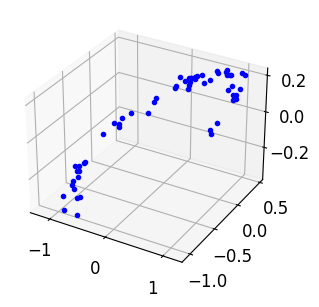

In [ ]:
# A 3D plot of output:
fig = plt.figure(figsize=(4,3))
ax = plt.axes(projection='3d')
ax.plot(out[:,0], out[:, 1], out[:, 2], "b.") ; # b. => Blue with dot color
plt.grid(True) ;
save_fig("Output plot") ;
plt.show() ;

In [ ]:
# Model 3 summary
autoencoder.summary()

# Stacked Autoencoders

The stacked autoencoder is an approach to train deep networks consisting of multiple layers trained using the greedy approach. An example of a stacked autoencoder is shown in the following diagram:

image.png

Getting ready

The preceding diagram demonstrates a stacked autoencoder with two layers. A stacked autoencoder can have n layers, where each layer is trained using one layer at a time. For example, the previous layer will be trained as follows:

image.png

Training of a stacked autoencoder

The initial pre-training of layer 1 is obtained by training it over the actual input xi . The first step is to optimize the We(1) layer of the encoder with respect to output X. The second step in the preceding example is to optimize the weights We(2) in the second layer, using We(1) as input and output. Once all the layers of We(i) where i=1, 2, ...,n is number of layers are pretrained, model fine-tuning is performed by connecting all the layers together

Stacked autoencoder can be used for classification task:

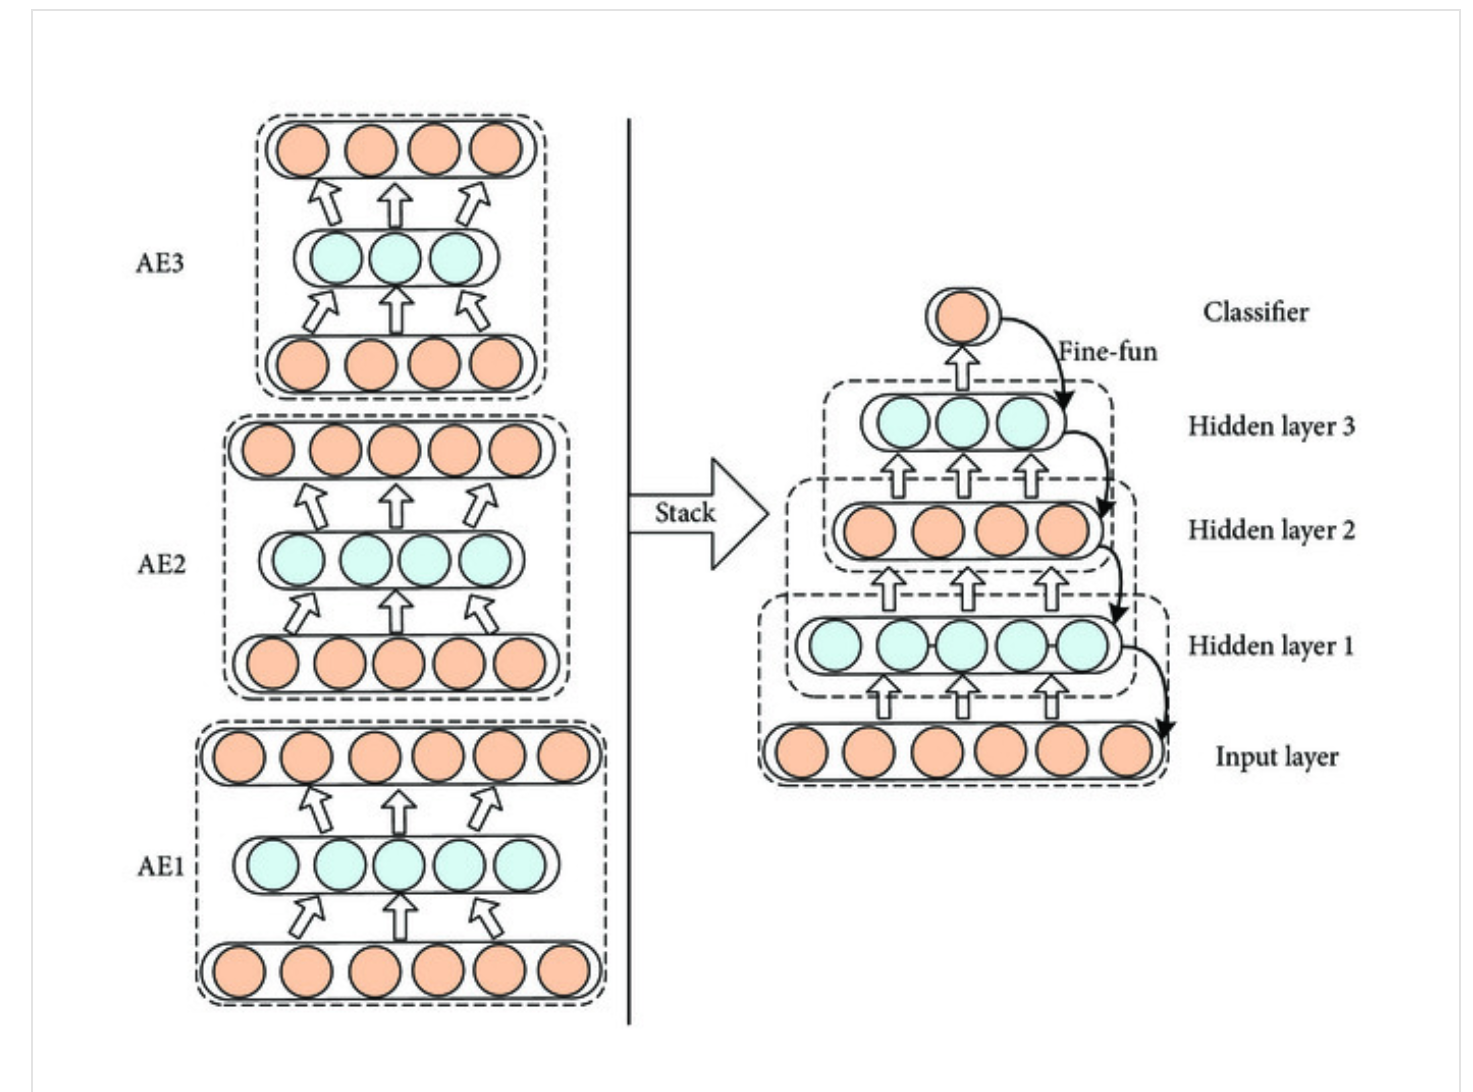

Let's use MNIST:

In [15]:
# Import mnist data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data();

4422102/4422102 [==============================] - 1s 0us/step


In [16]:
# Normalize data:

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# We will work with a smaller dataset
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Two deep a stackencoder may perform very well inso far as output may be an exact copy of inputs. But such autoencoders may fail to generalize in so far as codings are concerned. Too many weights may learn *any* codings not only the grneralised codings.

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

### What is selu activation function:

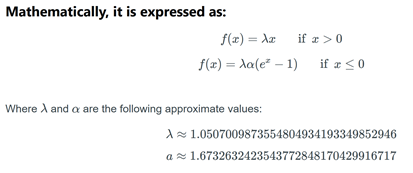

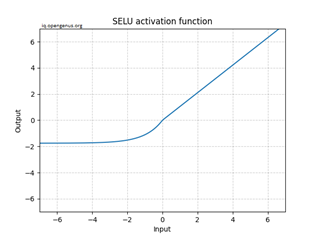

For a more thorough discussion on why selu perform normalization also, see StackOverflow [here](https://stackoverflow.com/a/61042244/3282777)

In [ ]:
# Calculate accuracy:
def rounded_accuracy(y_true, y_pred):
    # tf.round(x) rounds the values of x to integer values.
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
stacked_encoder = keras.models.Sequential(
                                            [
                                              keras.Input(shape = [28,28]),
                                              keras.layers.Flatten(),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(30, activation="selu"),
                                            ]
                                          )

In [ ]:
stacked_decoder = keras.models.Sequential(
                                            [
                                              keras.Input(shape =[30]),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(28 * 28, activation="sigmoid"),
                                              keras.layers.Reshape([28, 28])
                                            ]
                                          )

In [ ]:
stacked_ae = keras.models.Sequential([
                                      stacked_encoder,
                                      stacked_decoder
                                      ]
                                     )


In [ ]:
stacked_ae.compile(
                   loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5),
                   metrics=[rounded_accuracy]
                   )

In [ ]:
history = stacked_ae.fit(X_train,
                         X_train, epochs=20,
                         validation_data=(X_valid, X_valid)
                         )

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3447 - rounded_accuracy: 0.8836 - val_loss: 0.3193 - val_rounded_accuracy: 0.9010
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3120 - rounded_accuracy: 0.9089 - val_loss: 0.3108 - val_rounded_accuracy: 0.9091
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3054 - rounded_accuracy: 0.9144 - val_loss: 0.3029 - val_rounded_accuracy: 0.9187
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3008 - rounded_accuracy: 0.9184 - val_loss: 0.3007 - val_rounded_accuracy: 0.9194
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2983 - rounded_accuracy: 0.9204 - val_loss: 0.2992 - val_rounded_accuracy: 0.9221
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2962 - rounded_accuracy: 0.9222 - val_loss: 0.2981 - val_rounded_accuracy: 0.9209
Epoch 7/20
1719/1719 [==============

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [ ]:
# Repeat our eatlier function:

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
X_valid[0].shape
print(X_valid[0])

(28, 28)

[[0.         0.         0.         0.         0.         0.
  0.         0.00784314 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00784314 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.09411765 0.6745098  0.654902
  0.38431373 0.34509805 0.32941177 0.36862746 0.41568628 0.5803922
  0.7294118  0.2901961  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.42745098 0.8666667  0.90588236 0.9411765  0.93333334
  0.9372549  0.9411765  0.88235295 0.9019608  0.9411765  0.93333334
  0.9372549  0.93333334 0.8235294  0.67058825 0.11764706 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.7176471  0.95686275 0.8784314  0.8352941  0.83

In [18]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Original image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + image_index
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        # Reconstructed image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + n_images + image_index
        #  ie the next row
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 39ms/step
Saving figure reconstruction_plot


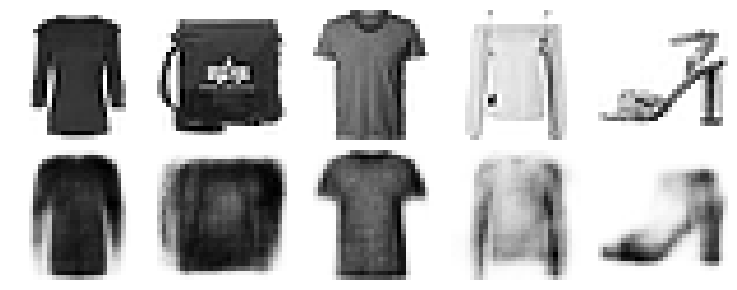

In [ ]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

# Visualizing Fashion MNIST

Codings from stackautoencoder can be used as input to tsne:

In [ ]:
# Import tsne library:
from sklearn.manifold import TSNE

In [ ]:
# PErform tsne
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


In [ ]:
# Normalize it for plotting
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

(0.007764644548296923,
 1.0472493026405574,
 -0.04721985161304474,
 0.9916168838739395)

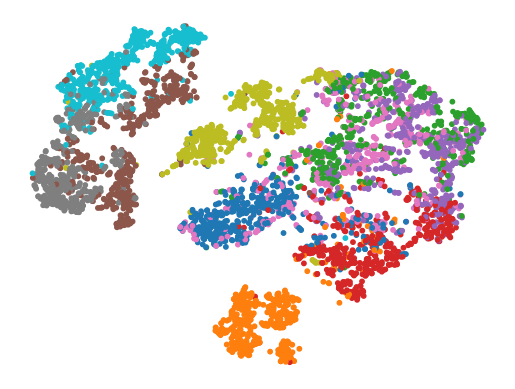

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

<Figure size 1000x800 with 0 Axes>

(0.007764644548296923,
 1.0472493026405574,
 -0.04721985161304474,
 0.9916168838739395)

Saving figure fashion_mnist_visualization_plot


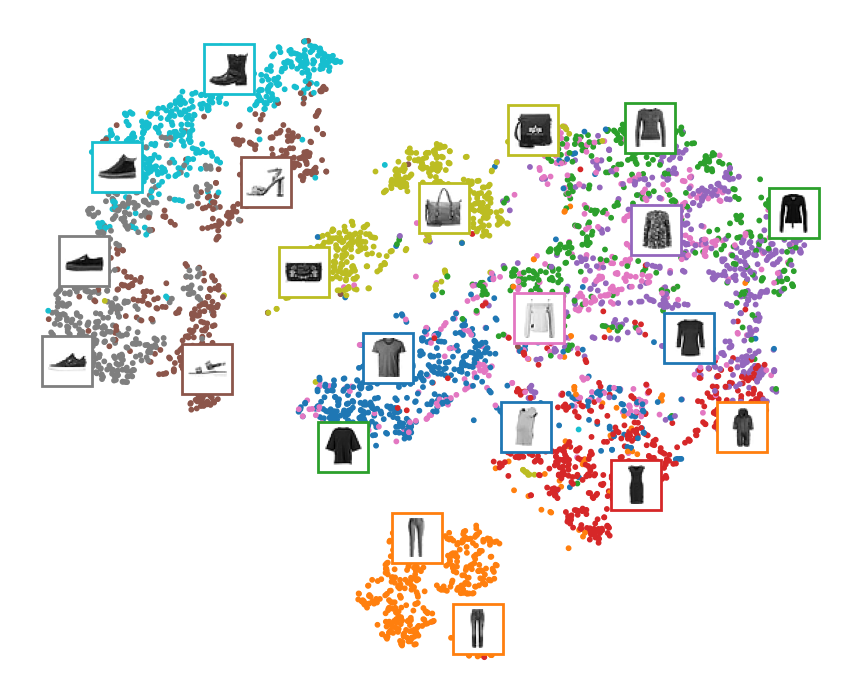

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## ecg data

In [53]:
header = [ "c" + str(i) for i in range(210)]
data_tr = pd.read_csv("http://s3.amazonaws.com/h2o-public-test-data/smalldata/anomaly/ecg_discord_train.csv", header = None , names = header)
data_te = pd.read_csv("http://s3.amazonaws.com/h2o-public-test-data/smalldata/anomaly/ecg_discord_test.csv", header = None , names = header)
data_tr.head(3)
data_tr.shape
data_te.head(3)
data_te.shape

c0    c1    c2    c3    c4    c5    c6    c7    c8    c9  ...  c200  \
0  2.10  2.13  2.19  2.28  2.44  2.62  2.80  3.04  3.36  3.69  ...  2.99   
1  2.06  2.05  2.06  2.07  2.08  2.13  2.22  2.37  2.53  2.71  ...  3.62   
2  2.05  2.05  2.03  2.02  2.03  2.04  2.08  2.14  2.28  2.44  ...  3.71   

   c201  c202  c203  c204  c205  c206  c207  c208  c209  
0  2.74  2.61  2.47  2.35  2.26  2.20  2.15  2.10  2.08  
1  3.38  3.17  2.92  2.64  2.45  2.33  2.23  2.13  2.08  
2  3.33  3.01  2.74  2.55  2.51  2.30  2.17  2.10  2.08  

[3 rows x 210 columns]

(20, 210)

c0    c1    c2    c3    c4    c5    c6    c7    c8    c9  ...  c200  \
0  2.10  2.13  2.19  2.28  2.44  2.62  2.80  3.04  3.36  3.69  ...  2.99   
1  2.06  2.05  2.06  2.07  2.08  2.13  2.22  2.37  2.53  2.71  ...  3.62   
2  2.05  2.05  2.03  2.02  2.03  2.04  2.08  2.14  2.28  2.44  ...  3.71   

   c201  c202  c203  c204  c205  c206  c207  c208  c209  
0  2.74  2.61  2.47  2.35  2.26  2.20  2.15  2.10  2.08  
1  3.38  3.17  2.92  2.64  2.45  2.33  2.23  2.13  2.08  
2  3.33  3.01  2.74  2.55  2.51  2.30  2.17  2.10  2.08  

[3 rows x 210 columns]

(23, 210)

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
ss = StandardScaler()
tr = ss.fit_transform(data_tr)
te = ss.transform(data_te)

In [130]:
stacked_encoder = keras.models.Sequential(
                                            [
                                              keras.Input(shape = [210]),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(30, activation="selu"),
                                            ]
                                          )

In [131]:
stacked_decoder = keras.models.Sequential(
                                            [
                                              keras.Input(shape =[30]),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(210, activation="selu"),
                                            ]
                                          )

In [132]:
stacked_ae = keras.models.Sequential([
                                      stacked_encoder,
                                      stacked_decoder
                                      ]
                                     )


In [133]:
stacked_ae.compile(
                   loss="mse",
                   optimizer=  "adam" , #keras.optimizers.SGD(learning_rate=1.5),
                   metrics=["mse"]
                   )

In [134]:
history = stacked_ae.fit(tr,
                         tr, epochs=100,
                         )

Epoch 1/100
1/1 [==============================] - 1s 944ms/step - loss: 1.5134 - mse: 1.5134
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 1.2711 - mse: 1.2711
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 1.1320 - mse: 1.1320
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0246 - mse: 1.0246
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.9352 - mse: 0.9352
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.8625 - mse: 0.8625
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 0.7999 - mse: 0.7999
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7387 - mse: 0.7387
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6790 - mse: 0.6790
Epoch 10/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6228 - mse: 0.6228
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - l

In [135]:
pe_tr = stacked_ae.predict(tr)
pe_te = stacked_ae.predict(te)


1/1 [==============================] - 0s 24ms/step


In [136]:
dx = (np.square(pe_te - te)).mean(axis=1)
dx

array([3.86079938e-02, 1.63410622e-02, 2.80881619e-02, 5.72245116e-02,
       2.56903250e-02, 4.01798792e-02, 5.15050889e-02, 4.55632668e-02,
       2.61587547e-02, 1.85327228e-02, 3.14086732e-02, 2.33397476e-02,
       2.28447507e-02, 3.56295959e-02, 6.81926914e-02, 5.18986030e-02,
       2.50120308e-02, 2.96585265e-02, 4.99724784e-02, 2.11487007e-01,
       3.92671141e+01, 1.34426274e+02, 1.07410177e+02])

In [137]:
plt.boxplot(dx);

In [138]:
m = dx[:-3].mean()
s = dx[:-3].std()
m
print("\n==========\n")
s
print("\n==========\n")
m  + 3 * s
print("\n==========\n")
m -  3 * s

0.04486679356012211

0.04061225000009424

0.16670354356040482

-0.07696995644016061

## Training one Autoencoder at a Time

In [ ]:
# Import mnist data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data();

In [ ]:
# Normalize data:

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# We will work with a smaller dataset
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):

    # n_neurons: codings size

    # No of input features:
    n_inputs = X_train.shape[-1]

    # Single layer encoder:
    encoder = keras.models.Sequential(
                                        [
                                          keras.Input(shape = [n_inputs]),
                                          keras.layers.Dense(n_neurons,
                                                             activation="selu",
                                                             )
                                        ]
                                      )

    decoder = keras.models.Sequential(
                                       [
                                        keras.Input(shape = [n_neurons]),
                                        keras.layers.Dense(n_inputs,
                                                           activation=output_activation
                                                           ),
                                       ]
                                      )


    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(optimizer, loss, metrics=metrics)

    autoencoder.fit(X_train,
                    X_train,
                    epochs=n_epochs,
                    validation_data=(X_valid, X_valid)
                    )

    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
X_train_flat.shape  # TensorShape([55000, 784]
X_valid_flat.shape  # TensorShape([5000, 784])

TensorShape([55000, 784])

TensorShape([5000, 784])

In [ ]:
# Train Ist encoder-decoder:
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
                                                            100,
                                                            X_train_flat,
                                                            X_valid_flat,
                                                            "binary_crossentropy",
                                                             keras.optimizers.SGD(learning_rate=1.5),
                                                             output_activation="sigmoid",
                                                             metrics=[rounded_accuracy]
                                                            )

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3449 - rounded_accuracy: 0.8872 - val_loss: 0.3121 - val_rounded_accuracy: 0.9148
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3039 - rounded_accuracy: 0.9205 - val_loss: 0.3008 - val_rounded_accuracy: 0.9243
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2954 - rounded_accuracy: 0.9282 - val_loss: 0.2941 - val_rounded_accuracy: 0.9314
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2898 - rounded_accuracy: 0.9337 - val_loss: 0.2895 - val_rounded_accuracy: 0.9355
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2861 - rounded_accuracy: 0.9373 - val_loss: 0.2864 - val_rounded_accuracy: 0.9383
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2834 - rounded_accuracy: 0.9399 - val_loss: 0.2841 - val_rounded_accuracy: 0.9408
Epoch 7/10
1719/1719 [==========

In [ ]:
# Train IInd encoder/decoder
enc2, dec2, _, _ = train_autoencoder(
                                     30,  # Codings size
                                     X_train_enc1,
                                     X_valid_enc1,
                                     "mse",  # Note not binary crossentropy
                                     keras.optimizers.SGD(learning_rate=0.05),
                                     output_activation="selu"
                                     )


Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5915 - val_loss: 0.3182
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2949 - val_loss: 0.2752
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2639 - val_loss: 0.2510
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2360 - val_loss: 0.2229
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2180 - val_loss: 0.2057
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.1963 - val_loss: 0.1896
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1895 - val_loss: 0.1894
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1860 - val_loss: 0.1831
Epoch 9/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1844 - val_loss: 0.1815
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1

In [ ]:
stacked_ae_1_by_1 = keras.models.Sequential(
                                               [
                                                    keras.layers.Flatten(input_shape=[28, 28]),
                                                    enc1,
                                                    enc2,
                                                    dec2,
                                                    dec1,
                                                    keras.layers.Reshape([28, 28])
                                                ]
                                              )

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Original image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + image_index
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        # Reconstructed image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + n_images + image_index
        #  ie the next row
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

1/1 [==============================] - 0s 102ms/step


In [ ]:
stacked_ae_1_by_1.compile(
                          loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1),
                          metrics=[rounded_accuracy]
                          )


In [ ]:
history = stacked_ae_1_by_1.fit(X_train,
                                X_train,
                                epochs=10,
                                validation_data=(X_valid, X_valid)
                                )

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.2866 - rounded_accuracy: 0.9348 - val_loss: 0.2882 - val_rounded_accuracy: 0.9348
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2862 - rounded_accuracy: 0.9352 - val_loss: 0.2879 - val_rounded_accuracy: 0.9351
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2859 - rounded_accuracy: 0.9355 - val_loss: 0.2876 - val_rounded_accuracy: 0.9352
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2857 - rounded_accuracy: 0.9357 - val_loss: 0.2875 - val_rounded_accuracy: 0.9355
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2856 - rounded_accuracy: 0.9359 - val_loss: 0.2873 - val_rounded_accuracy: 0.9356
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2854 - rounded_accuracy: 0.9360 - val_loss: 0.2872 - val_rounded_accuracy: 0.9355
Epoch 7/10
1719/1719 [==============

1/1 [==============================] - 0s 85ms/step


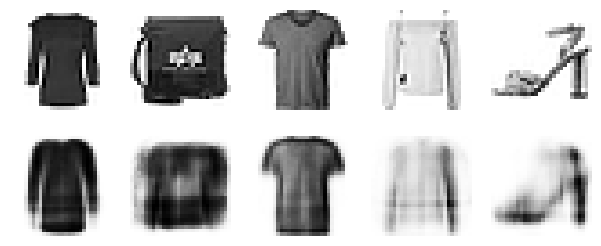

In [ ]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## ecg data

In [115]:
def train_autoencoder(n_neurons, X_train,  loss, optimizer,
                      n_epochs=100, output_activation=None, metrics=None):

    # n_neurons: codings size

    # No of input features:
    n_inputs = X_train.shape[-1]

    # Single layer encoder:
    encoder = keras.models.Sequential(
                                        [
                                          keras.Input(shape = [n_inputs]),
                                          keras.layers.Dense(n_neurons,
                                                             activation="selu",
                                                             )
                                        ]
                                      )

    decoder = keras.models.Sequential(
                                       [
                                        keras.Input(shape = [n_neurons]),
                                        keras.layers.Dense(n_inputs,
                                                           activation=output_activation
                                                           ),
                                       ]
                                      )


    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(optimizer, loss, metrics=metrics)

    autoencoder.fit(X_train,
                    X_train,
                    epochs=n_epochs,
                    #validation_data=(X_valid, X_valid)
                    )

    return encoder, decoder, encoder(X_train)

In [116]:
# Train Ist encoder-decoder:
enc1, dec1, X_train_enc1 = train_autoencoder(
                                                100,
                                                tr,
                                                "mse",
                                                "adam",
                                                  output_activation="selu",
                                                  metrics=["mse"]
                                                )

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.7477 - mse: 1.7477
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 1.4768 - mse: 1.4768
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 1.2494 - mse: 1.2494
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 1.0656 - mse: 1.0656
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.9182 - mse: 0.9182
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.8016 - mse: 0.8016
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.7083 - mse: 0.7083
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 0.6320 - mse: 0.6320
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5675 - mse: 0.5675
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5123 - mse: 0.5123
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss

In [117]:
# Train IInd encoder/decoder
enc2, dec2, _ = train_autoencoder(
                                     30,  # Codings size
                                     X_train_enc1,
                                     "mse",  # Note not binary crossentropy
                                     "adam",
                                     output_activation="selu"
                                     )


Epoch 1/100
1/1 [==============================] - 1s 540ms/step - loss: 1.6904
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 1.6096
Epoch 3/100
1/1 [==============================] - 0s 15ms/step - loss: 1.5334
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 1.4622
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 1.3964
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 1.3356
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 1.2796
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 1.2279
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 1.1796
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 1.1336
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - loss: 1.0908
Epoch 12/100
1/1 [==============================] - 0s 14ms/step - loss: 1.0509
Epoch 13/100
1/1 [==============================

In [118]:
stacked_ae_1_by_1 = keras.models.Sequential(
                                              [
                                                keras.layers.Flatten(input_shape=[210]),
                                                enc1,
                                                enc2,
                                                dec2,
                                                dec1,
                                              ]
                                              )

In [122]:
stacked_ae_1_by_1.compile(
                          loss="mse",
                          optimizer="adam",
                          metrics=["mse"]
                          )


In [123]:
history = stacked_ae_1_by_1.fit(tr,
                                tr,
                                epochs=100,
                                #validation_data=(X_valid, X_valid)
                                )

Epoch 1/100
1/1 [==============================] - 1s 932ms/step - loss: 0.1036 - mse: 0.1036
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.1124 - mse: 0.1124
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0947 - mse: 0.0947
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0919 - mse: 0.0919
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0890 - mse: 0.0890
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0823 - mse: 0.0823
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0761 - mse: 0.0761
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0738 - mse: 0.0738
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0728 - mse: 0.0728
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0697 - mse: 0.0697
Epoch 11/100
1/1 [==============================] - 0s 16ms/step - l

In [126]:
pe_tr = stacked_ae_1_by_1.predict(tr)
pe_te = stacked_ae_1_by_1.predict(te)


1/1 [==============================] - 0s 36ms/step


In [127]:
dx = (np.square(pe_te - te)).mean(axis=1)
dx

array([2.01710769e-02, 6.08181099e-03, 1.63263321e-02, 2.54320502e-02,
       1.04685737e-02, 6.50592559e-03, 1.94202216e-03, 5.77338641e-03,
       5.60029716e-03, 6.57030883e-03, 9.55776274e-03, 5.49050531e-03,
       1.11713842e-02, 1.06325547e-02, 1.85114501e-02, 5.62824529e-03,
       8.32214386e-03, 7.31995074e-03, 6.68595907e-03, 1.80640659e-01,
       3.98424784e+01, 1.28133922e+02, 9.81962502e+01])

In [128]:
plt.boxplot(dx);

In [129]:
m = dx[:-3].mean()
s = dx[:-3].std()
m
print("\n==========\n")
s
print("\n==========\n")
m  + 3 * s
print("\n==========\n")
m -  3 * s


0.018441619946711674

0.037650480659257184

0.13139306192448322

-0.09450982203105987

## Using Convolutional Layers Instead of Dense Layers  
What are CNN? See [here](https://cs231n.github.io/convolutional-networks/)

In [ ]:
from IPython import display
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/2_strided_conv_do_not_smush.gif?size=395x381&lossy=2&strip=1&webp=1')

### How Convolutional Transpose layer works

Also called Deconvolution See [here](https://blog.paperspace.com/transpose-convolution/)

Image size calculation:

>In the equation for convolutioanl output size, replace output by input and vice versa. Then, rearrange variables:   
> <i>Convolutional output size = 1 + (input size - filter size + 2 * padding ) / stride</i>
>> image.png

To get:

> <i>Convolutional transpose output size = (input size - 1) * strides + filter size - 2 * padding  + output padding <i>  

See discussion [here](https://stackoverflow.com/questions/54751574/understanding-output-shape-of-keras-conv2dtranspose)




In [ ]:
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/3_fractional_strided_conv_do_not_smush.gif?size=395x449&lossy=2&strip=1&webp=1')

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
conv_encoder = keras.models.Sequential([
                                        keras.Input(shape = (28,28)),
                                        keras.layers.Reshape([28, 28, 1]),
                                        keras.layers.Conv2D(16,
                                                            kernel_size=3,
                                                            padding="SAME",
                                                            activation="selu"
                                                            ),

                                       keras.layers.MaxPool2D(pool_size=2),
                                       keras.layers.Conv2D(32,
                                                           kernel_size=3,
                                                           padding="SAME",
                                                           activation="selu"
                                                           ),

                                        keras.layers.MaxPool2D(pool_size=2),
                                        keras.layers.Conv2D(64,
                                                            kernel_size=3,
                                                            padding="SAME",
                                                            activation="selu"
                                                            ),
                                        keras.layers.MaxPool2D(pool_size=2)
                                        ]
                                       )


conv_encoder.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)        

In [ ]:
# (input size - 1) * strides + filter size - 2 * padding  + output padding
conv_decoder = keras.models.Sequential(
                                        [
                                          keras.Input(shape = [3, 3, 64]),
                                          keras.layers.Conv2DTranspose(32,
                                                                      kernel_size=3,
                                                                      strides=2,
                                                                      padding="VALID",  # padding is zero
                                                                      activation="selu",
                                                                      ),  # (3 -1) * 2 + 3 -2 * 0 + 0
                                          keras.layers.Conv2DTranspose(16,
                                                                      kernel_size=3,
                                                                      strides=2,
                                                                      padding="SAME",
                                                                      activation="selu"
                                                                      ),  # (7-1) * 2 + 3 -2 +1
                                          keras.layers.Conv2DTranspose(1,
                                                                      kernel_size=3,
                                                                      strides=2,
                                                                      padding="SAME",  # padding is 1
                                                                      activation="sigmoid"
                                                                      ),  # (14 - 1) * 2 + 3 - 2 +1
                                          #keras.layers.Reshape([28, 28])
                                        ]
                                      )

conv_decoder.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_18 (Conv2  (None, 7, 7, 32)          18464     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_19 (Conv2  (None, 14, 14, 16)        4624      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_20 (Conv2  (None, 28, 28, 1)         145       
 DTranspose)                                                     
                                                                 
Total params: 23233 (90.75 KB)
Trainable params: 23233 (90.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [ ]:
conv_ae.compile(
                 loss="binary_crossentropy",
                 optimizer=keras.optimizers.SGD(learning_rate=1.0),
                 metrics=[rounded_accuracy]
                 )

In [ ]:
history = conv_ae.fit(X_train,
                      X_train,
                      epochs=5,
                      validation_data=(X_valid, X_valid)
                      )

Epoch 1/5
1719/1719 [==============================] - 65s 37ms/step - loss: 0.3010 - rounded_accuracy: 0.9192 - val_loss: 0.2795 - val_rounded_accuracy: 0.9402
Epoch 2/5
1719/1719 [==============================] - 61s 36ms/step - loss: 0.2760 - rounded_accuracy: 0.9411 - val_loss: 0.2747 - val_rounded_accuracy: 0.9439
Epoch 3/5
1719/1719 [==============================] - 81s 47ms/step - loss: 0.2712 - rounded_accuracy: 0.9460 - val_loss: 0.2703 - val_rounded_accuracy: 0.9490
Epoch 4/5
1719/1719 [==============================] - 82s 47ms/step - loss: 0.2685 - rounded_accuracy: 0.9487 - val_loss: 0.2678 - val_rounded_accuracy: 0.9515
Epoch 5/5
1719/1719 [==============================] - 81s 47ms/step - loss: 0.2667 - rounded_accuracy: 0.9505 - val_loss: 0.2683 - val_rounded_accuracy: 0.9509


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

In [ ]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders
Your runtime should be GPU

In [ ]:
recurrent_encoder = keras.models.Sequential(
                                             [
                                               keras.layers.LSTM(100,
                                                                 return_sequences=True,
                                                                 input_shape=[28, 28]
                                                                 ),
                                                keras.layers.LSTM(30)
                                             ]
                                            )

recurrent_encoder.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 28, 100)           51600     
                                                                 
 lstm_7 (LSTM)               (None, 30)                15720     
                                                                 
Total params: 67320 (262.97 KB)
Trainable params: 67320 (262.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


RepeatVector is used to repeat the input for set number, n of times. For example, if RepeatVector with argument 16 is applied to layer having input shape as (batch_size, 32), then the output shape of the layer will be (batch_size, 16, 32)

In [ ]:
recurrent_decoder = keras.models.Sequential(
                                               [
                                                  keras.Input(shape =[30] ),
                                                  keras.layers.RepeatVector(28),

                                                  # There will be 28 LSTMs
                                                  keras.layers.LSTM(100,  # Dimensionality of the output space.
                                                                    return_sequences=True
                                                                    ),

                                                  # There will be 28 dense layers, one over each
                                                  #   return_sequence
                                                  # Because TimeDistributed applies the same instance of Dense to each
                                                  #   of the timestamps, the same set of weights are used at
                                                  #    each timestamp.
                                                  #    Weights areL 28 * 100 + 28 (bias) = 2828
                                                  keras.layers.TimeDistributed(
                                                                                keras.layers.Dense(
                                                                                                   28,
                                                                                                   activation="sigmoid"
                                                                                                   )
                                                                                )
                                               ]
                                           )

recurrent_decoder.summary()


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_3 (RepeatVec  (None, 28, 30)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 28, 100)           52400     
                                                                 
 time_distributed_3 (TimeDi  (None, 28, 28)            2828      
 stributed)                                                      
                                                                 
Total params: 55228 (215.73 KB)
Trainable params: 55228 (215.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])


In [ ]:
recurrent_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy]
                     )

In [ ]:
history = recurrent_ae.fit(X_train,
                           X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid)
                           )

Epoch 1/10
1719/1719 [==============================] - 142s 78ms/step - loss: 0.5234 - rounded_accuracy: 0.7380 - val_loss: 0.4569 - val_rounded_accuracy: 0.8035
Epoch 2/10
1719/1719 [==============================] - 136s 79ms/step - loss: 0.4136 - rounded_accuracy: 0.8366 - val_loss: 0.3823 - val_rounded_accuracy: 0.8561
Epoch 3/10
1719/1719 [==============================] - 142s 82ms/step - loss: 0.3696 - rounded_accuracy: 0.8658 - val_loss: 0.3610 - val_rounded_accuracy: 0.8737
Epoch 4/10
1719/1719 [==============================] - 160s 93ms/step - loss: 0.3553 - rounded_accuracy: 0.8783 - val_loss: 0.3508 - val_rounded_accuracy: 0.8830
Epoch 5/10
1719/1719 [==============================] - 158s 92ms/step - loss: 0.3455 - rounded_accuracy: 0.8842 - val_loss: 0.3415 - val_rounded_accuracy: 0.8893
Epoch 6/10
1719/1719 [==============================] - 147s 86ms/step - loss: 0.3371 - rounded_accuracy: 0.8894 - val_loss: 0.3344 - val_rounded_accuracy: 0.8909
Epoch 7/10
1719/1719 [

1/1 [==============================] - 1s 1s/step


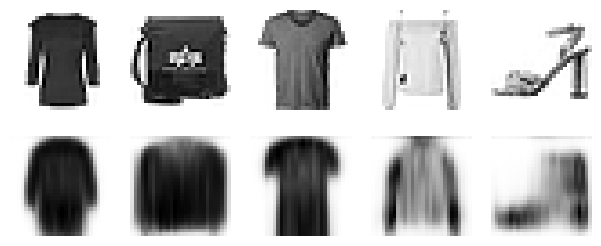

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder  
Better use GPU  

Using Gaussian noise:

In [ ]:
# tf.keras.layers.GaussianNoise(stddev)
denoising_encoder = keras.models.Sequential(
                                             [
                                                keras.Input(shape = [28,28]),
                                                keras.layers.Flatten(),
                                                # tf.keras.layers.GaussianNoise(stddev)
                                                keras.layers.GaussianNoise(0.2),  # Adds noise to each neuron at the
                                                                                  #   input during runtime
                                                keras.layers.Dense(100, activation="selu"),
                                                keras.layers.Dense(30, activation="selu")
                                              ]
                                            )

In [ ]:

denoising_decoder = keras.models.Sequential(
                                             [
                                                keras.Input(shape = [30]),
                                                keras.layers.Dense(100, activation="selu"),
                                                keras.layers.Dense(28 * 28, activation="sigmoid"),
                                                keras.layers.Reshape([28, 28])
                                              ]
                                             )


In [ ]:
denoising_ae = keras.models.Sequential(
                                       [denoising_encoder,
                                        denoising_decoder])


In [ ]:
denoising_ae.compile(
                     loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy]
                     )

In [ ]:
history = denoising_ae.fit(X_train,
                           X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid)
                           )

Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.3497 - rounded_accuracy: 0.8779 - val_loss: 0.3176 - val_rounded_accuracy: 0.9086
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3119 - rounded_accuracy: 0.9101 - val_loss: 0.3080 - val_rounded_accuracy: 0.9116
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3047 - rounded_accuracy: 0.9163 - val_loss: 0.3044 - val_rounded_accuracy: 0.9141
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3014 - rounded_accuracy: 0.9191 - val_loss: 0.3000 - val_rounded_accuracy: 0.9199
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2990 - rounded_accuracy: 0.9211 - val_loss: 0.2970 - val_rounded_accuracy: 0.9245
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2972 - rounded_accuracy: 0.9226 - val_loss: 0.2962 - val_rounded_accuracy: 0.9266
Epoch 7/10
1719/1719 [===========

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Original image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + image_index
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        # Reconstructed image
        # The figure has 2 rows, n_images columns, and this plot is at 1 + n_images + image_index
        #  ie the next row
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
# To add noise to X_valid
# Create a layer that adds noise to its inputs:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

1/1 [==============================] - 0s 28ms/step


## ecg

In [145]:
# tf.keras.layers.GaussianNoise(stddev)
denoising_encoder = keras.models.Sequential(
                                             [
                                                keras.Input(shape = [210]),
                                                keras.layers.GaussianNoise(0.2),  # Adds noise to each neuron at the
                                                                                  #   input during runtime
                                                keras.layers.Dense(100, activation="selu"),
                                                keras.layers.Dense(30, activation="selu")
                                              ]
                                            )

denoising_decoder = keras.models.Sequential(
                                             [
                                                keras.Input(shape = [30]),
                                                keras.layers.Dense(100, activation="selu"),
                                                keras.layers.Dense(210, activation="selu"),
                                              ]
                                             )

denoising_ae = keras.models.Sequential(
                                       [denoising_encoder,
                                        denoising_decoder]
                                       )

denoising_ae.compile(
                     loss="mse",
                     optimizer = "adam",
                     metrics=["mse"],
                     )

history = denoising_ae.fit(tr,
                           tr,
                           epochs=100,
                           )


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.6044 - mse: 1.6044
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 1.3243 - mse: 1.3243
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 1.1466 - mse: 1.1466
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 1.0431 - mse: 1.0431
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.9752 - mse: 0.9752
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.8969 - mse: 0.8969
Epoch 7/100
1/1 [==============================] - 0s 19ms/step - loss: 0.8367 - mse: 0.8367
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.7857 - mse: 0.7857
Epoch 9/100
1/1 [==============================] - 0s 21ms/step - loss: 0.7311 - mse: 0.7311
Epoch 10/100
1/1 [==============================] - 0s 17ms/step - loss: 0.6760 - mse: 0.6760
Epoch 11/100
1/1 [==============================] - 0s 19ms/step - loss

1/1 [==============================] - 0s 23ms/step


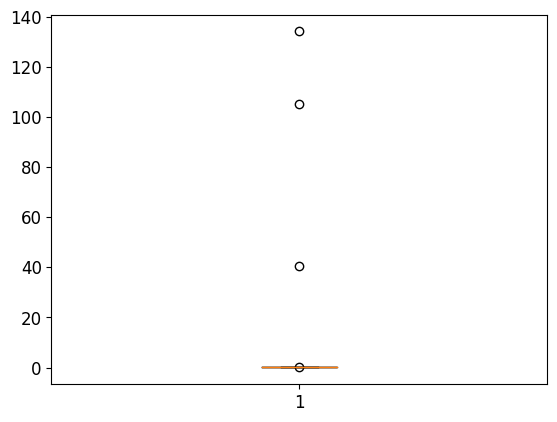

In [147]:
pe_tr = denoising_ae.predict(tr)
pe_te = denoising_ae.predict(te)
dx = (np.square(pe_te - te)).mean(axis=1)
dx
plt.boxplot(dx);

In [148]:
m = dx[:-3].mean()
s = dx[:-3].std()
m
print("\n==========\n")
s
print("\n==========\n")
m  + 3 * s
print("\n==========\n")
m -  3 * s

0.05582630901366823

0.04179519460163424

0.18121189281857095

-0.0695592747912345

Using dropout:  
But use GPU

In [ ]:
dropout_encoder = keras.models.Sequential(
                                           [
                                              keras.layers.Flatten(input_shape=[28, 28]),
                                              keras.layers.Dropout(0.5),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(30, activation="selu")
                                           ]
                                          )


dropout_decoder = keras.models.Sequential(
                                           [
                                              keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                              keras.layers.Dense(28 * 28, activation="sigmoid"),
                                              keras.layers.Reshape([28, 28])
                                            ]
                                          )

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy]
                   )

history = dropout_ae.fit(X_train,
                         X_train,
                         epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3550 - rounded_accuracy: 0.8723 - val_loss: 0.3194 - val_rounded_accuracy: 0.9058
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3184 - rounded_accuracy: 0.9029 - val_loss: 0.3120 - val_rounded_accuracy: 0.9099
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3128 - rounded_accuracy: 0.9071 - val_loss: 0.3074 - val_rounded_accuracy: 0.9143
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3094 - rounded_accuracy: 0.9101 - val_loss: 0.3048 - val_rounded_accuracy: 0.9147
Epoch 5/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3069 - rounded_accuracy: 0.9121 - val_loss: 0.3026 - val_rounded_accuracy: 0.9171
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3050 - rounded_accuracy: 0.9136 - val_loss: 0.3006 - val_rounded_accuracy: 0.9197
Epoch 7/10
1719/1719 [==========

1/1 [==============================] - 0s 84ms/step
Saving figure dropout_denoising_plot


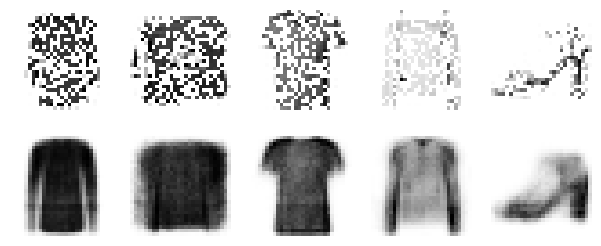

In [ ]:
# Add dropout as here:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

## ecg

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [ ]:
simple_encoder = keras.models.Sequential([
                                            keras.layers.Flatten(input_shape=[28, 28]),
                                            keras.layers.Dense(100, activation="selu"),
                                            keras.layers.Dense(30, activation="sigmoid"),
                                          ]
                                         )

simple_decoder = keras.models.Sequential(
                                            [
                                                keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                                keras.layers.Dense(28 * 28, activation="sigmoid"),
                                                keras.layers.Reshape([28, 28])
                                            ]
                                          )



In [ ]:
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])

In [ ]:
simple_ae.compile(loss="binary_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy]
                  )



In [ ]:
history = simple_ae.fit(X_train,
                        X_train,
                        epochs=10,
                        validation_data=(X_valid, X_valid)
                        )

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4279 - rounded_accuracy: 0.8005 - val_loss: 0.3757 - val_rounded_accuracy: 0.8512
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3597 - rounded_accuracy: 0.8686 - val_loss: 0.3503 - val_rounded_accuracy: 0.8768
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3399 - rounded_accuracy: 0.8873 - val_loss: 0.3353 - val_rounded_accuracy: 0.8928
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3272 - rounded_accuracy: 0.8974 - val_loss: 0.3254 - val_rounded_accuracy: 0.8973
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3208 - rounded_accuracy: 0.9021 - val_loss: 0.3208 - val_rounded_accuracy: 0.9040
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3177 - rounded_accuracy: 0.9045 - val_loss: 0.3184 - val_rounded_accuracy: 0.9068
Epoch 7/10
1719/1719 [==============

1/1 [==============================] - 0s 92ms/step


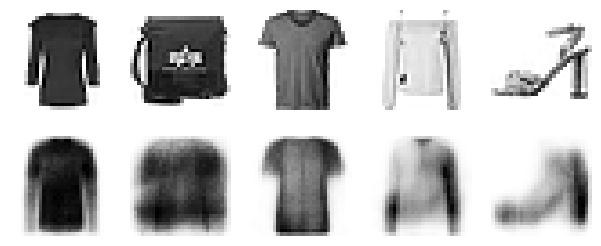

In [ ]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [ ]:
sparse_l1_encoder = keras.models.Sequential([
                                              keras.layers.Flatten(input_shape=[28, 28]),
                                              keras.layers.Dense(100, activation="selu"),
                                              keras.layers.Dense(300, activation="sigmoid"),
                                              keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                                                            # activity_regularizer=keras.regularizers.l1(1e-3)
                                                                                            # to the previous layer.
                                            ])

sparse_l1_decoder = keras.models.Sequential(
                                              [
                                                keras.layers.Dense(100, activation="selu", input_shape=[300]),
                                                keras.layers.Dense(28 * 28, activation="sigmoid"),
                                                keras.layers.Reshape([28, 28])
                                              ]
                                            )



Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4329 - rounded_accuracy: 0.8148 - val_loss: 0.3801 - val_rounded_accuracy: 0.8610
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3693 - rounded_accuracy: 0.8694 - val_loss: 0.3659 - val_rounded_accuracy: 0.8748
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3554 - rounded_accuracy: 0.8802 - val_loss: 0.3504 - val_rounded_accuracy: 0.8858
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3439 - rounded_accuracy: 0.8877 - val_loss: 0.3435 - val_rounded_accuracy: 0.8845
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3371 - rounded_accuracy: 0.8923 - val_loss: 0.3364 - val_rounded_accuracy: 0.8933
Epoch 6/10
1719/1719 [==============================] - 21s 13ms/step - loss: 0.3305 - rounded_accuracy: 0.8984 - val_loss: 0.3317 - val_rounded_accuracy: 0.8934
Epoch 7/10
1719/1719 [========

In [ ]:
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [ ]:
sparse_l1_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy]
                     )

history = sparse_l1_ae.fit(X_train,
                           X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_l1_ae)

1/1 [==============================] - 0s 95ms/step


# Variational Autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.3889 - rounded_accuracy: 0.8608 - val_loss: 0.3592 - val_rounded_accuracy: 0.8840
Epoch 2/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3429 - rounded_accuracy: 0.8974 - val_loss: 0.3369 - val_rounded_accuracy: 0.8982
Epoch 3/25
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3329 - rounded_accuracy: 0.9050 - val_loss: 0.3356 - val_rounded_accuracy: 0.9022
Epoch 4/25
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3275 - rounded_accuracy: 0.9092 - val_loss: 0.3255 - val_rounded_accuracy: 0.9105
Epoch 5/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3243 - rounded_accuracy: 0.9119 - val_loss: 0.3232 - val_rounded_accuracy: 0.9169
Epoch 6/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.3219 - rounded_accuracy: 0.9138 - val_loss:

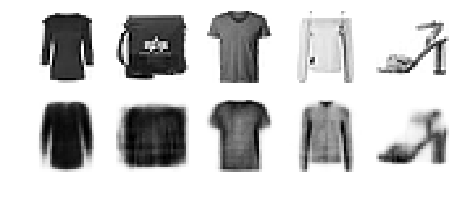

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure vae_generated_images_plot


Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


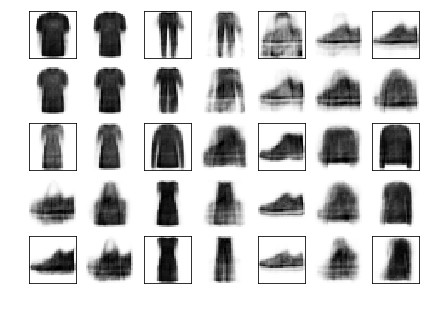

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


Saving figure gan_generated_images_plot


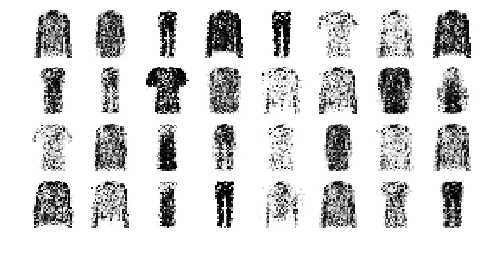

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


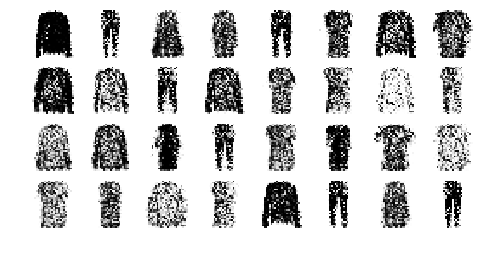

Epoch 2/50


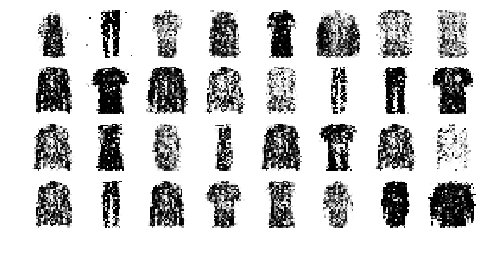

Epoch 3/50


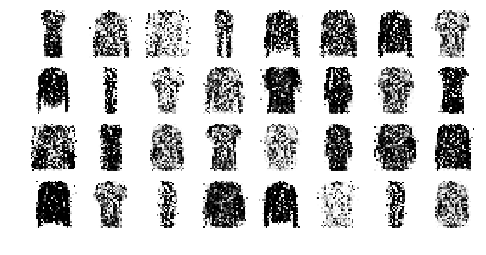

Epoch 4/50


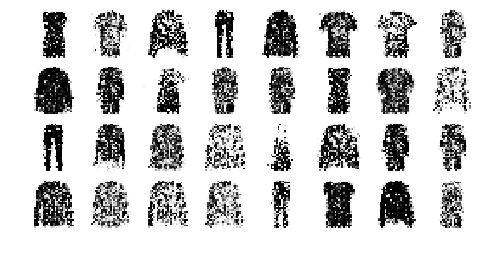

Epoch 5/50


Epoch 6/50


Epoch 7/50


Epoch 8/50


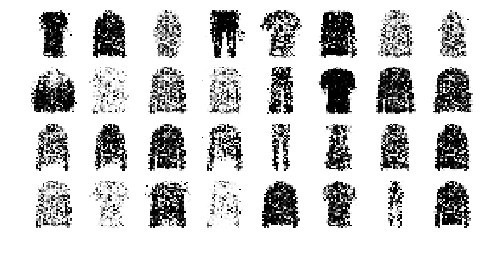

Epoch 9/50


Epoch 10/50


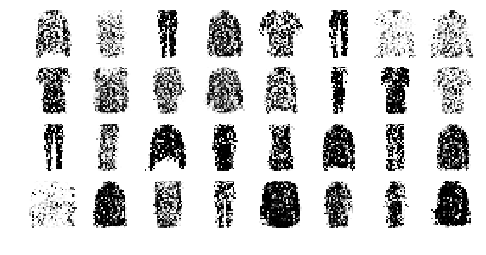

Epoch 11/50


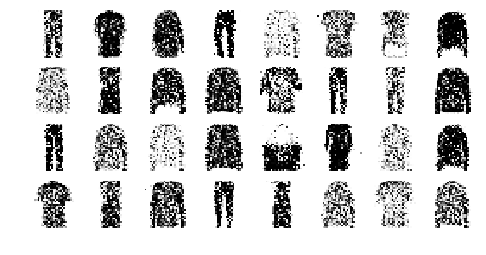

Epoch 12/50


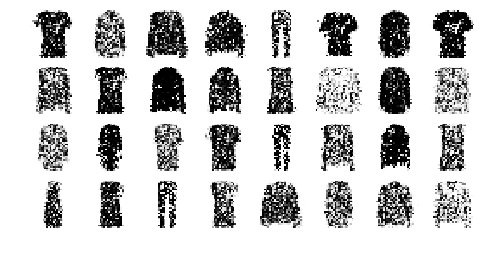

Epoch 13/50


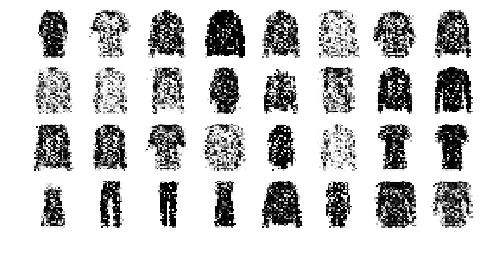

Epoch 14/50


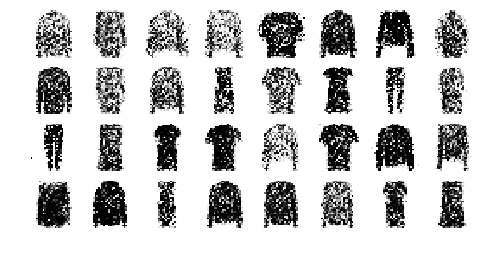

Epoch 15/50


Epoch 16/50


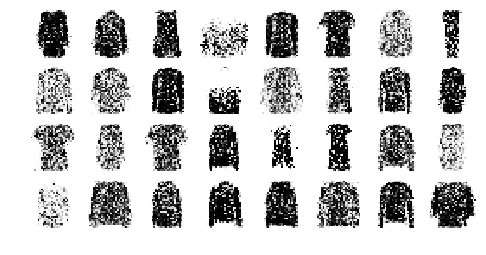

Epoch 17/50


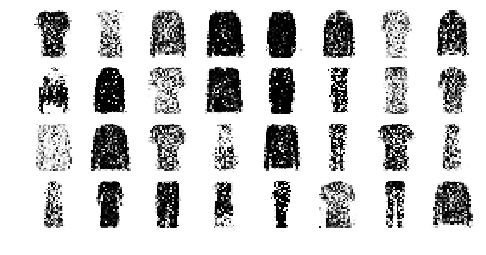

Epoch 18/50


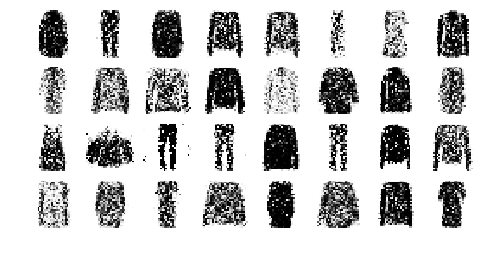

Epoch 19/50


Epoch 20/50


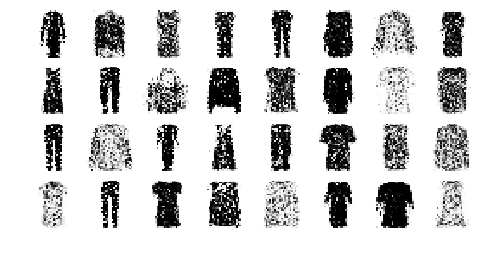

Epoch 21/50


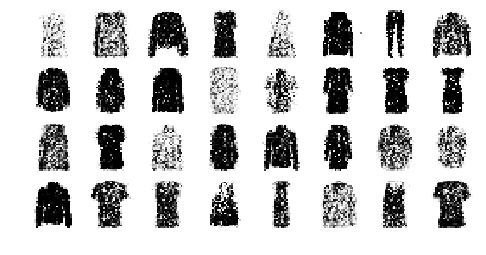

Epoch 22/50


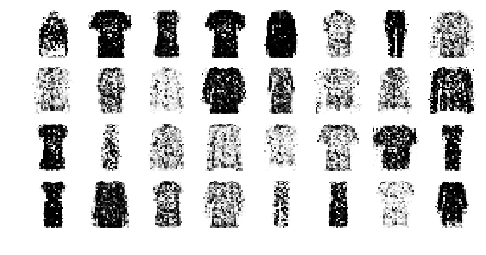

Epoch 23/50


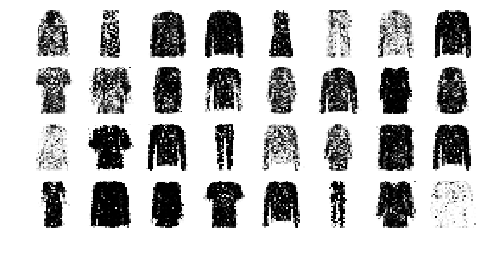

Epoch 24/50


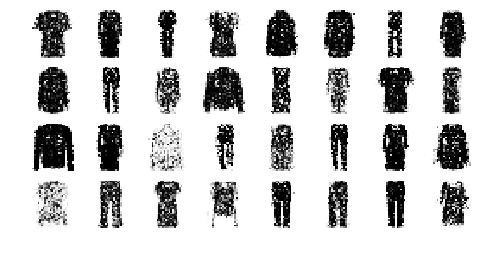

Epoch 25/50


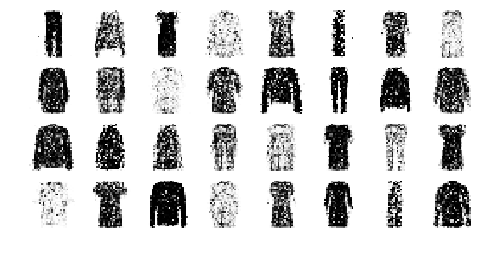

Epoch 26/50


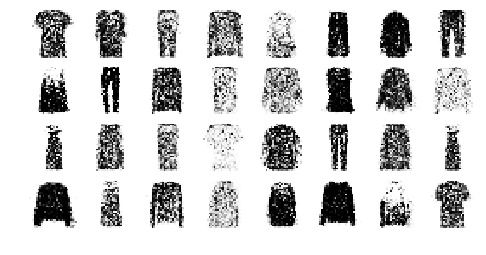

Epoch 27/50


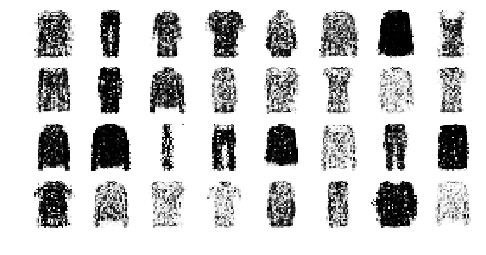

Epoch 28/50


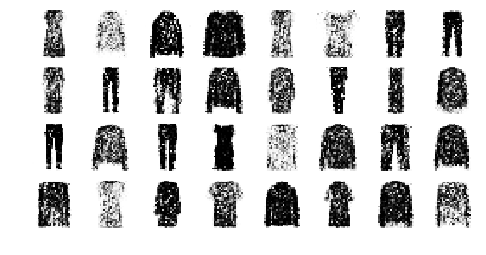

Epoch 29/50


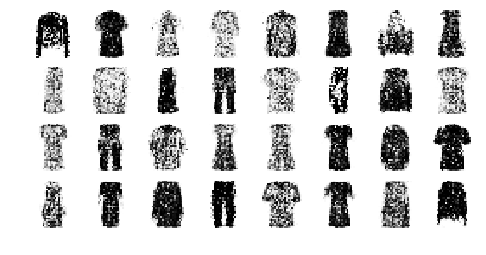

Epoch 30/50


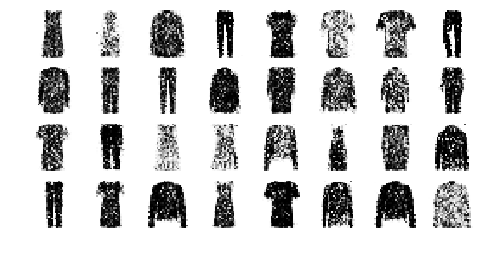

Epoch 31/50


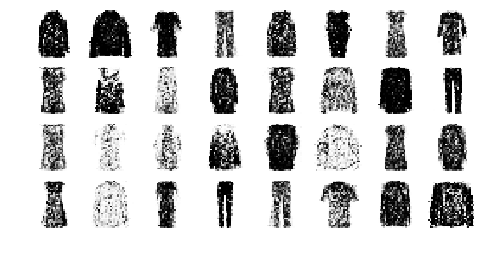

Epoch 32/50


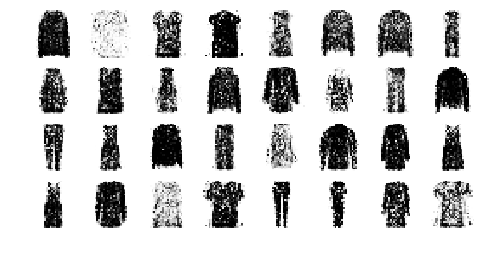

Epoch 33/50


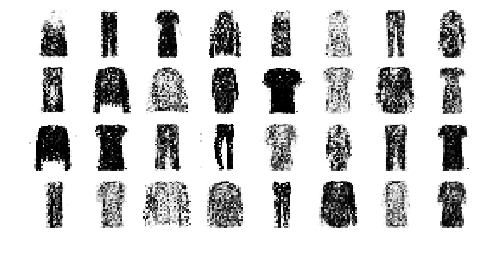

Epoch 34/50


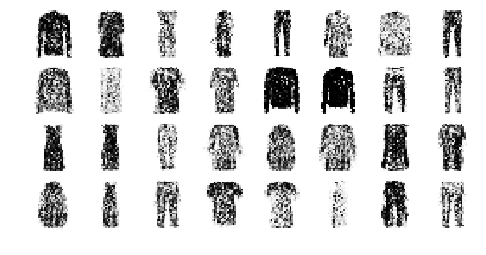

Epoch 35/50


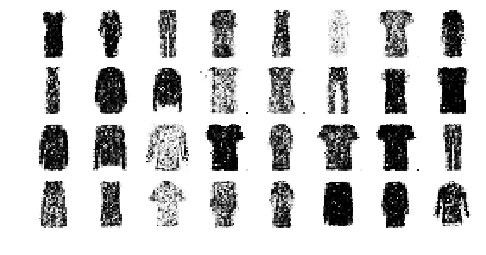

Epoch 36/50


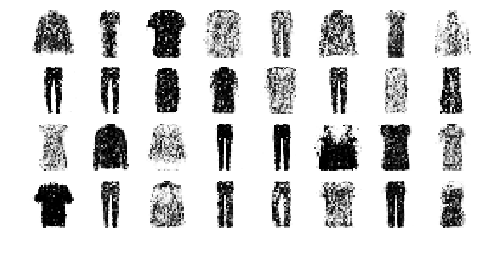

Epoch 37/50


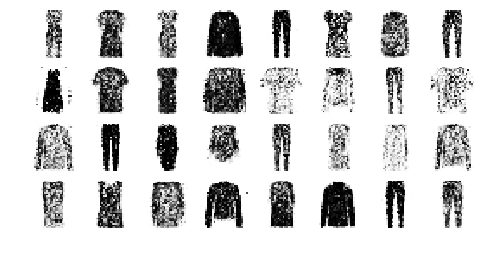

Epoch 38/50


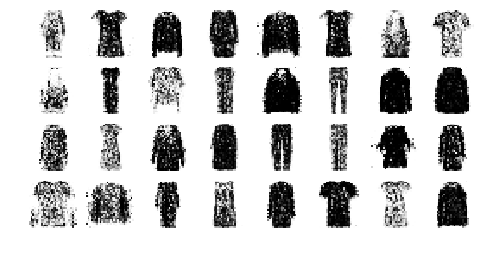

Epoch 39/50


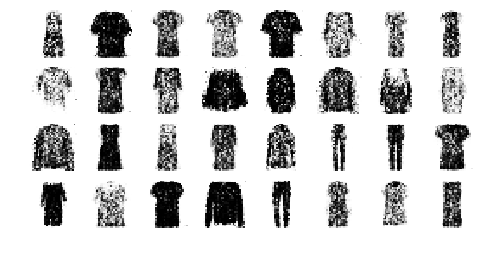

Epoch 40/50


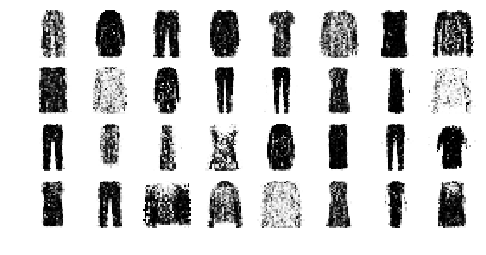

Epoch 41/50


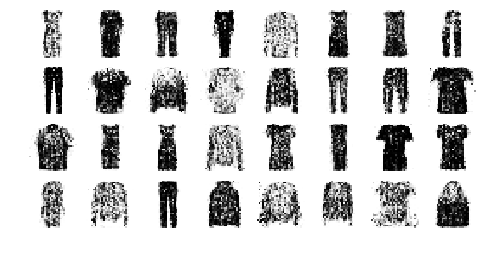

Epoch 42/50


Epoch 43/50


Epoch 44/50


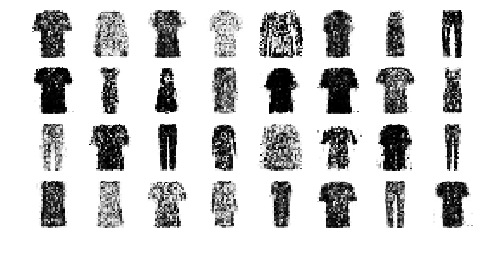

Epoch 45/50


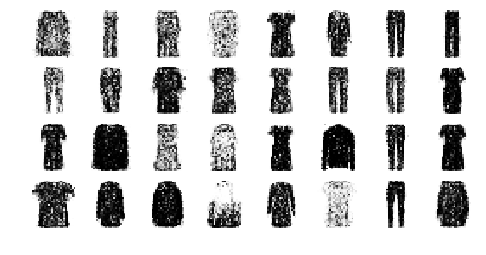

Epoch 46/50


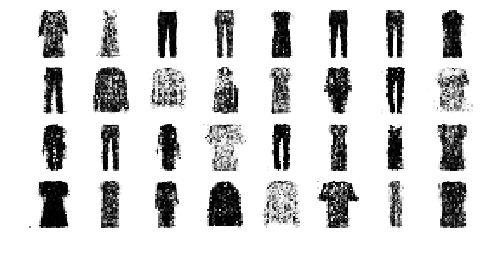

Epoch 47/50


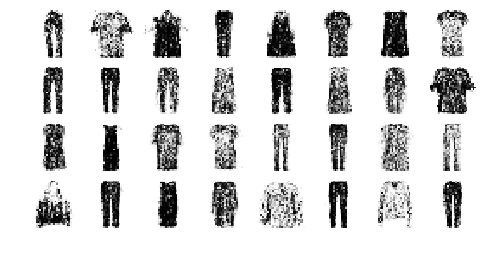

Epoch 48/50


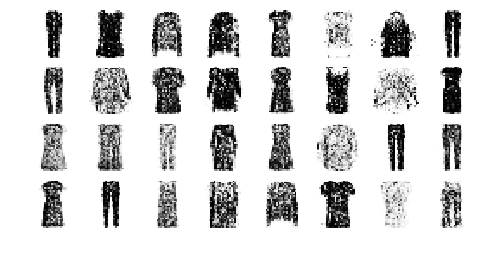

Epoch 49/50


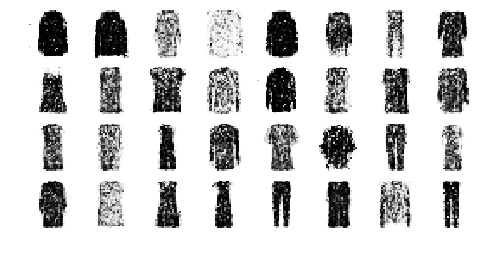

Epoch 50/50


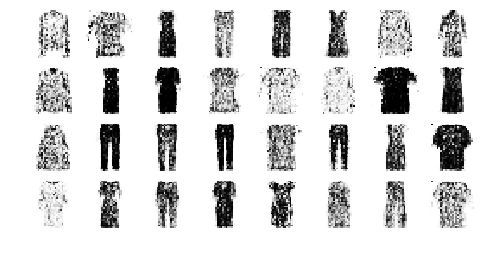

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
Saving figure gan_generated_images_plot


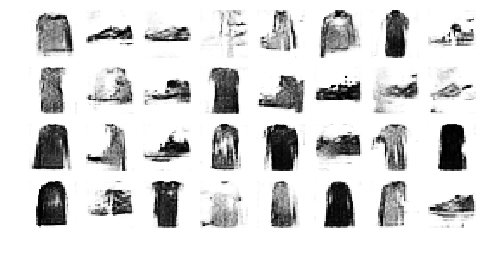

Epoch 2/50


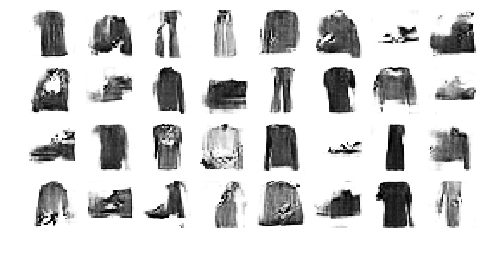

Epoch 3/50


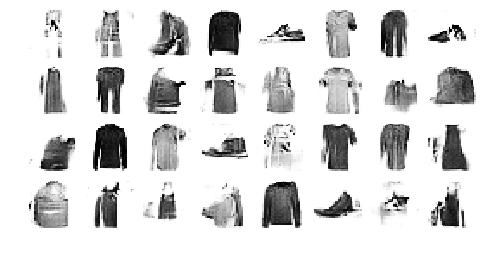

Epoch 4/50


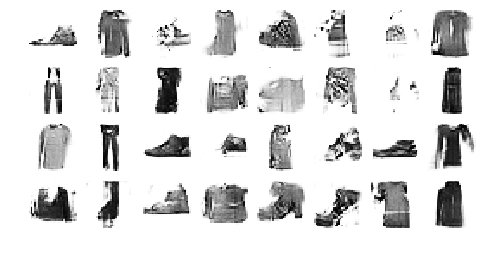

Epoch 5/50


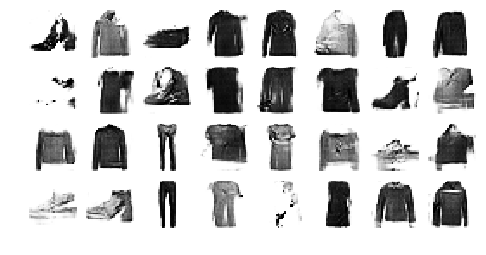

Epoch 6/50


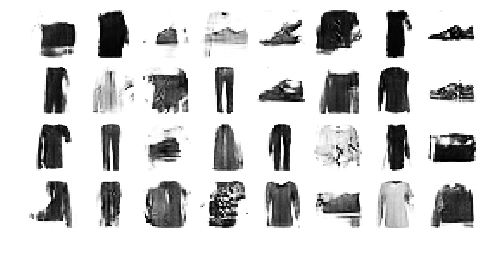

Epoch 7/50


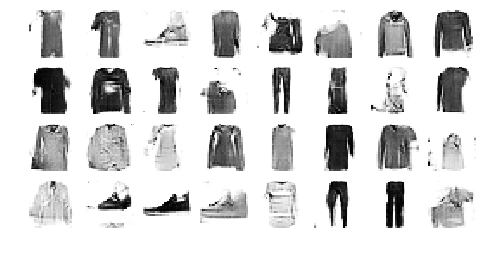

Epoch 8/50


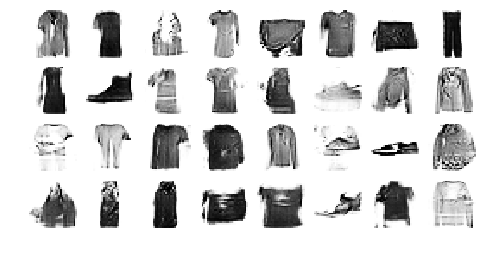

Epoch 9/50


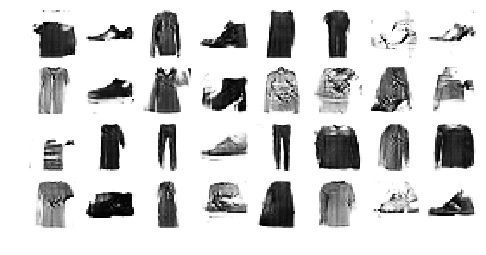

Epoch 10/50


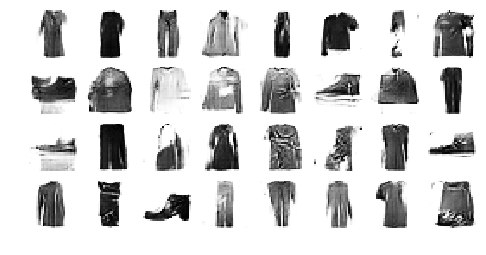

Epoch 11/50


Epoch 12/50


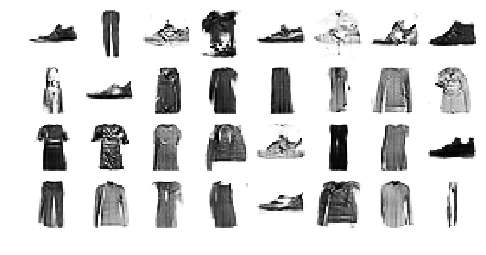

Epoch 13/50


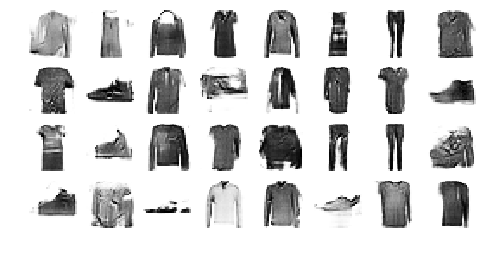

Epoch 14/50


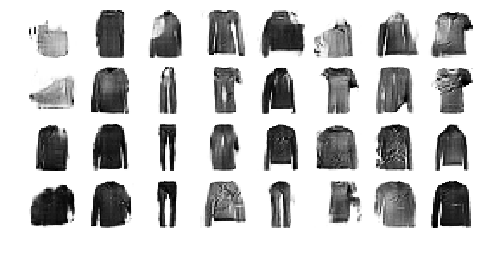

Epoch 15/50


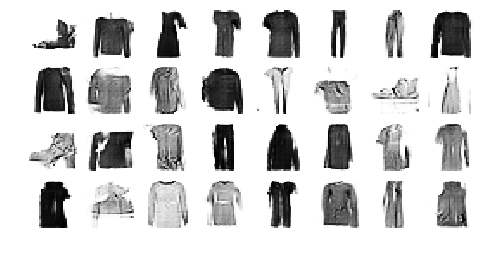

Epoch 16/50


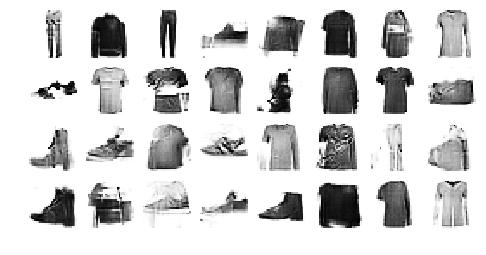

Epoch 17/50


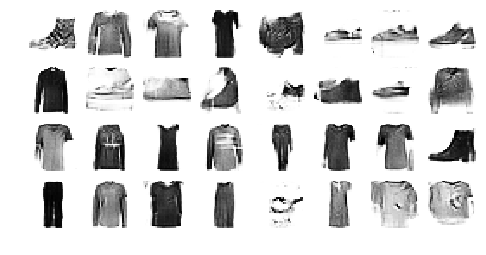

Epoch 18/50


Epoch 19/50


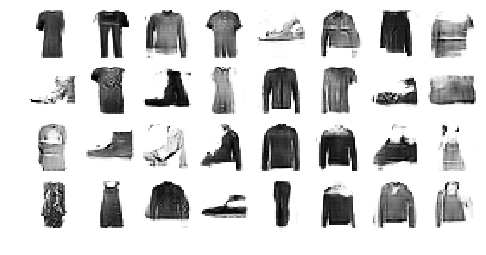

Epoch 20/50


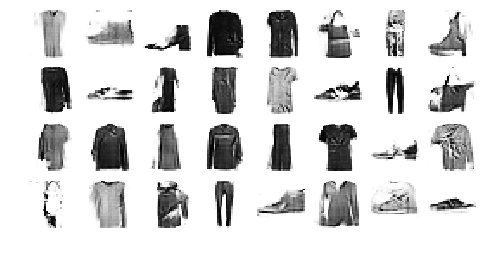

Epoch 21/50


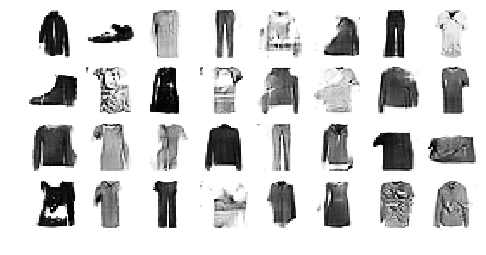

Epoch 22/50


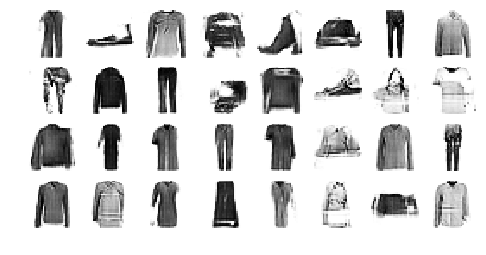

Epoch 23/50


Epoch 24/50


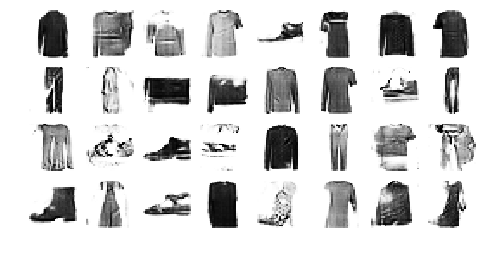

Epoch 25/50


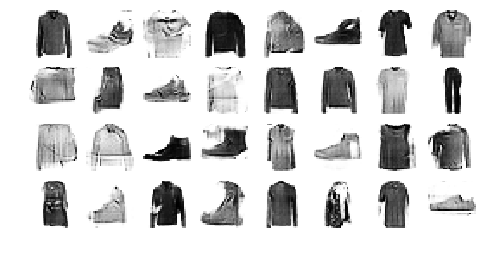

Epoch 26/50


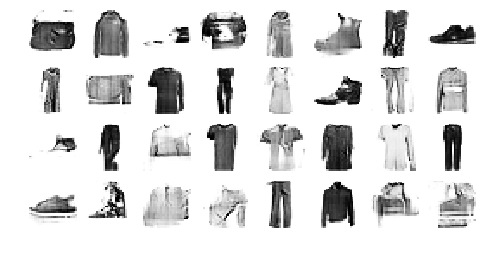

Epoch 27/50


Epoch 28/50


Epoch 29/50


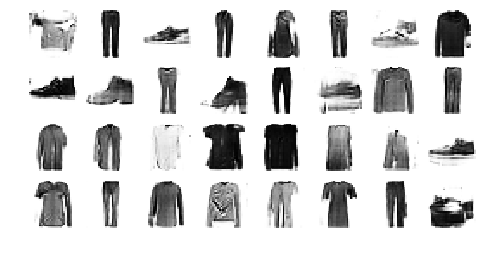

Epoch 30/50


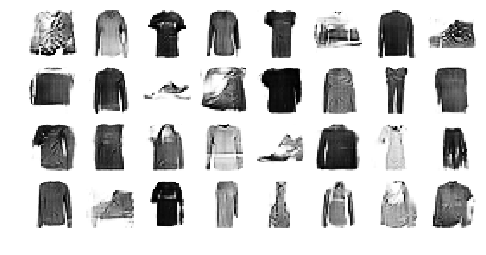

Epoch 31/50


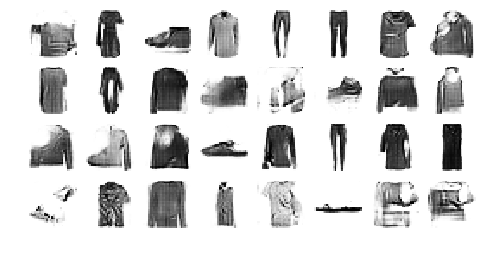

Epoch 32/50


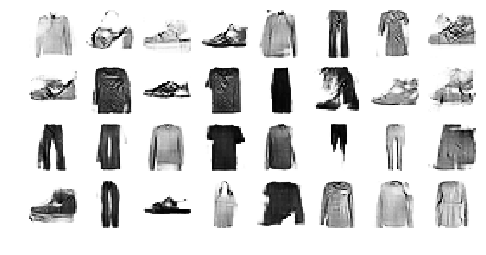

Epoch 33/50


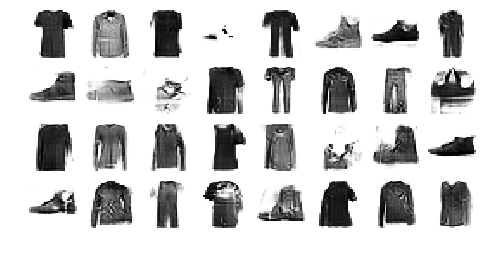

Epoch 34/50


Epoch 35/50


Epoch 36/50


Epoch 37/50


Epoch 38/50


Epoch 39/50


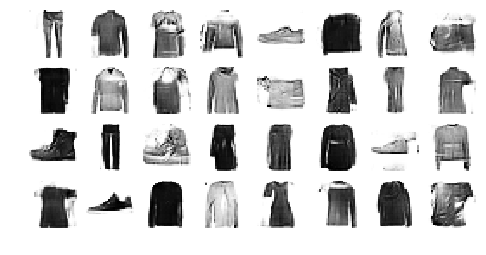

Epoch 40/50


Epoch 41/50


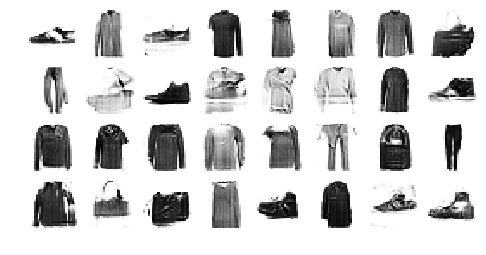

Epoch 42/50


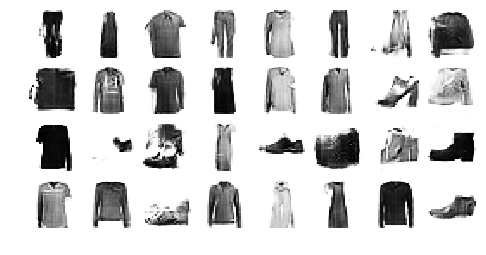

Epoch 43/50


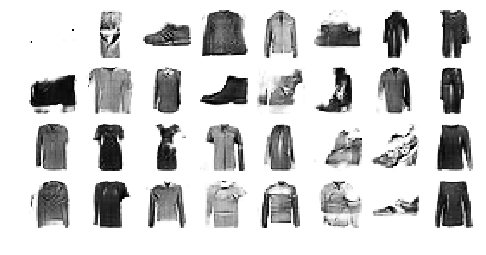

Epoch 44/50


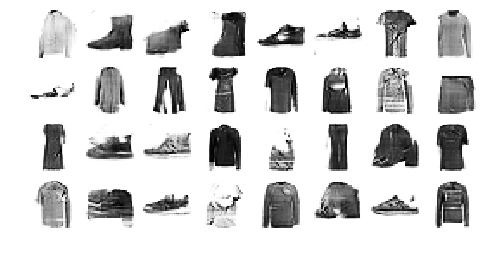

Epoch 45/50


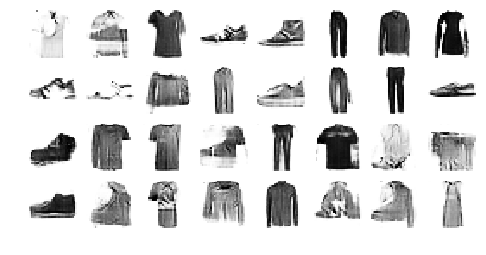

Epoch 46/50


Epoch 47/50


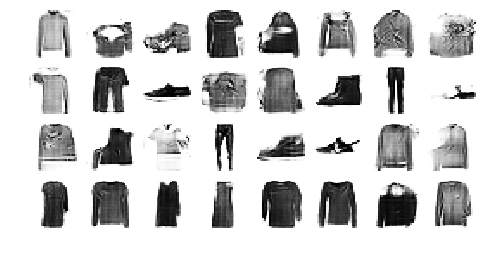

Epoch 48/50


Epoch 49/50


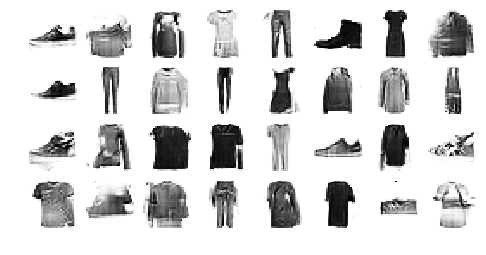

Epoch 50/50


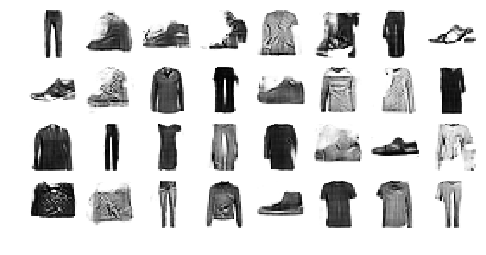

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

Saving figure dcgan_generated_images_plot


# Extra Material

## Hashing Using a Binary Autoencoder

Let's load the Fashion MNIST dataset again:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer to learn to output large values, since small values will just be crushed by the noise. In turn, this means that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that look alike will have the same hash. This can be very useful for search engines: for example, if we store each image on a server identified by the image's semantic hash, then all similar images will end up on the same server. Users of the search engine can then provide an image to search for, and the search engine will compute the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4462 - rounded_accuracy: 0.7827 - val_loss: 0.3881 - val_rounded_accuracy: 0.8251
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3712 - rounded_accuracy: 0.8455 - val_loss: 0.3706 - val_rounded_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3587 - rounded_accuracy: 0.8567 - val_loss: 0.3619 - val_rounded_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3532 - rounded_accuracy: 0.8631 - val_loss: 0.3559 - val_rounded_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3486 - rounded_accuracy: 0.8680 - val_loss: 0.3472 - val_rounded_accuracy: 0.8689
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3467 - rounded_accuracy: 0.8704 - val_loss: 0.3448 - val_rounded_accuracy: 0.8747
Epoch 7/10
1719/1719 [==================

The autoencoder compresses the information so much (down to 16 bits!) that it's quite lossy, but that's okay, we're using it to produce semantic hashes, not to perfectly reconstruct the images:

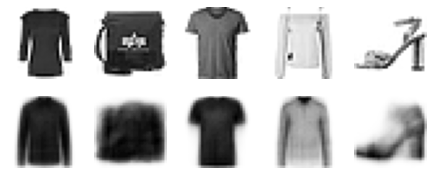

In [ ]:
show_reconstructions(hashing_ae)
plt.show()

Notice that the outputs are indeed very close to 0 or 1 (left graph):

In [ ]:
plot_activations_histogram(hashing_encoder)
plt.show()

Now let's see what the hashes look like for the first few images in the validation set:

In [ ]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100101011011
0000100100110011
0100100100011011
0001100111001010
0001010100110000
...


Now let's find the most common image hashes in the validation set, and display a few images for each hash. In the following image, all the images on a given row have the same hash:

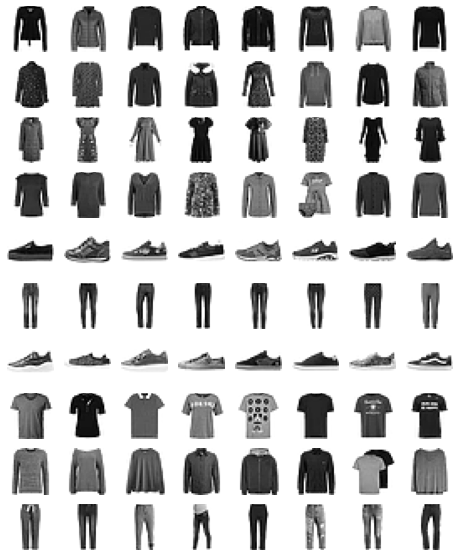

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Exercise Solutions

## 1. to 8.

See Appendix A.

## 9.
_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [ ]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [ ]:
denoising_encoder.summary()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_36 (GaussianN (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [ ]:
denoising_decoder.summary()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
reshape_22 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_62 (Conv2DT (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 160s 3ms/sample - loss: 0.5936 - mse: 0.0187 - val_loss: 0.5849 - val_mse: 0.0143
Epoch 2/10
50000/50000 [==============================] - 169s 3ms/sample - loss: 0.5727 - mse: 0.0100 - val_loss: 0.5783 - val_mse: 0.0117
Epoch 3/10
50000/50000 [==============================] - 183s 4ms/sample - loss: 0.5676 - mse: 0.0080 - val_loss: 0.5715 - val_mse: 0.0090
Epoch 4/10
50000/50000 [==============================] - 182s 4ms/sample - loss: 0.5653 - mse: 0.0071 - val_loss: 0.5695 - val_mse: 0.0083
Epoch 5/10
50000/50000 [==============================] - 185s 4ms/sample - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5687 - val_mse: 0.0079
Epoch 6/10
50000/50000 [==============================] - 158s 3ms/sample - loss: 0.5629 - mse: 0.0062 - val_loss: 0.5669 - val_mse: 0.0072
Epoch 7/10
50000/50000 [==============================] - 157s 3ms/sample - loss: 0.5622 - mse: 0.0060 - val_l

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

## 10.
_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._


## 11.
_Exercise: Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class._
